In [1]:
import matplotlib.pyplot as plt
import world_bank_data as wb
import scipy.stats as stats
import seaborn as sns
import numpy as np
import pandas as pd
import re

from matplotlib.lines import Line2D
from pathlib import Path

In [2]:
def extract_years(dates):
    # Extract the first and last years from a "dates_covered" string
    if pd.isna(dates):
        return (np.nan, np.nan)
    years = re.findall(r"\b\d{4}\b", str(dates))
    if len(years) < 2:
        return (np.nan, np.nan)
    return int(years[0]), int(years[1])

In [3]:
# Set paths 
root_p = Path("/Users/natashaclarke/winrepo/funders_project")
data_p = root_p / "data"
stats_p = data_p / "FundingAgencyStats - 2025-12-08_full_eu_breakdown_analysis.csv"
figures_p = root_p / "figures"
figures_p.mkdir(parents=True, exist_ok=True)

In [4]:
# Load data
df = pd.read_csv(stats_p)

In [5]:
# Total unique countries
num_countries = df['country'].nunique()

# Total unique funders
num_funders = df['label'].nunique()

# How many funders have data
funder_max = df.groupby('label').agg({
    'findable': 'max',
}).reset_index()
num_funders_with_data = (funder_max['findable'] == 1).sum()

print(f"Countries: {num_countries}")
print(f"Funders total: {num_funders}")
print(f"Funders with data: {num_funders_with_data}")

Countries: 33
Funders total: 40
Funders with data: 35


In [6]:
cols = [
    "findable","data_downloadable", "tabular", "english_data",
    "gender", "age","career_stage","age_or_career_stage", "parental_leave", "dei_eo_page",
    "year_of_award", "grant_duration", ">=3 years data", 
    "summary_funding", "per_group_funding", "report_all_applicants",
    "neuro_specific",
     "disability","ethnicity"]

# Collapse funders to their max values
funder_max = df.groupby('label')[cols].max().reset_index()

# Compute percentages
percentages = np.ceil(
    (funder_max[cols].sum() / len(funder_max) * 100)
    .reindex(cols)
).astype(int)

percentages_df = percentages.reset_index()
percentages_df.columns = ['Measure', 'Percent_of_Funders']

percentages_df

,Measure,Percent_of_Funders
0,findable,88
1,data_downloadable,73
2,tabular,25
3,english_data,73
4,gender,58
5,age,25
6,career_stage,63
7,age_or_career_stage,65
8,parental_leave,45
9,dei_eo_page,58


In [7]:
# Get the frequency of each data type
data_type_counts = df['data_type'].value_counts().reset_index()
data_type_counts.columns = ['data_type', 'count']

# Calculate percentages
data_type_counts['percentage'] = ((data_type_counts['count'] / data_type_counts['count'].sum()) * 100).round(0).astype(int)
data_type_counts

,data_type,count,percentage
0,annual_report,19,36
1,tabular,13,25
2,portal,10,19
3,report,6,11
4,list,5,9


In [8]:
# Calculate the widest range of data available per funder
# Extract start and end of funding years
df[["start_year", "end_year"]] = (df["dates_covered"].apply(extract_years).apply(pd.Series))
df["start_year"] = df["start_year"].astype("Int64")
df["end_year"] = df["end_year"].astype("Int64")
df.sort_values("start_year").head()

,checked since 09/2025,researcher,category,country,funder,label,data_type,dates_covered,findable,data_downloadable,...,neuro_specific,total_score,age,career_stage,disability,ethnicity,osf_file,notes,start_year,end_year
13,Y,NC,EU member,Denmark,Novo Nordisk Foundation,DK - Novo Nordisk Foundation (NNF),portal,1963-2025,1,0.0,...,0.0,6,0.0,0.0,0.0,0.0,NaN,NaN,1963,2025
54,Y,DP,Schengen area,Switzerland,SNSF,CH - Swiss National Science Foundation (SNSF),tabular,1974-2025,1,1.0,...,1.0,13,0.0,1.0,0.0,0.0,/Switzerland - SNSF/All_grants.csv,NaN,1974,2025
31,Y,DP,EU member,Netherlands,NWO,NL - Dutch Research Council (NWO),portal,1993-2025,1,0.0,...,0.0,7,0.0,0.0,0.0,0.0,Projectendatabank | NWO,NaN,1993,2025
0,Y,PM,EU member,Austria,FWF,AT - Austrian Science Fund (FWF),tabular,1995-2025,1,1.0,...,0.0,11,0.0,1.0,0.0,0.0,/Austria - FWF/PI-projects....csv + annual rep...,NaN,1995,2025
24,Y,PM,EU member,Italy,PRIN,IT - Research Projects of National Relevance (...,list,1999-2022,1,1.0,...,1.0,10,0.0,1.0,0.0,0.0,"N/A, list online (see https://prin.mur.gov.it/)",NaN,1999,2022


In [9]:
# Drop rows with no years
years_df = df.dropna(subset=["start_year"]).copy()

# Create the range of years for each funder
years_df["years_range"] = years_df.apply(lambda row: list(range(int(row["start_year"]), int(row["end_year"]) + 1)), axis=1)

# Expand into one row per year
years_df = years_df.explode("years_range").rename(columns={"years_range": "year"})

# Count unique funders per year
yearly_counts = years_df.groupby("year")["label"].nunique().reset_index()

In [10]:
sns.set_context("notebook", rc={
    "font.size": 14,         # base font size
    "axes.titlesize": 16,    # title
    "axes.labelsize": 14,    # axis labels
    "xtick.labelsize": 12,   # x ticks
    "ytick.labelsize": 12,   # y ticks
    "legend.fontsize": 12,   # legend
})

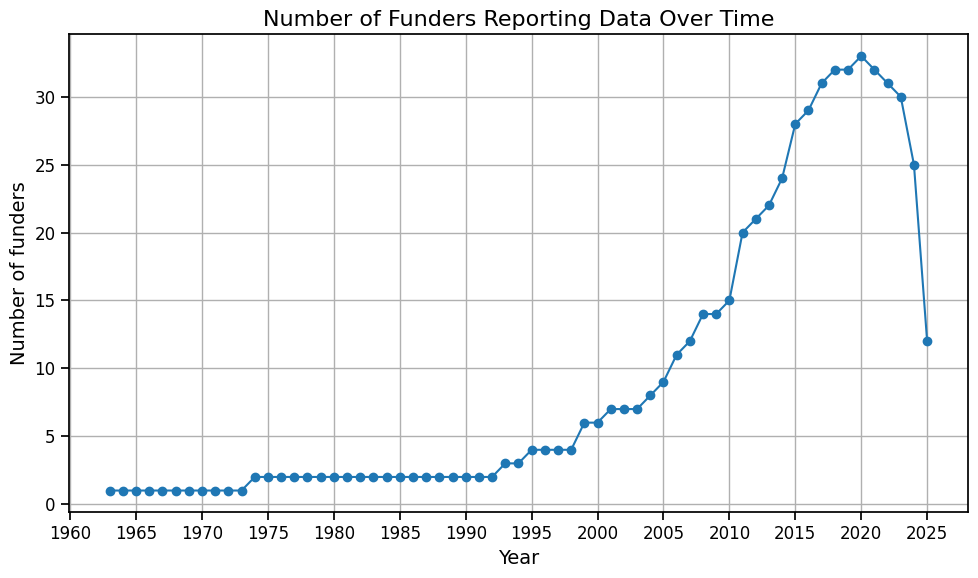

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(yearly_counts["year"], yearly_counts["label"], marker="o")
plt.title("Number of Funders Reporting Data Over Time")
plt.xlabel("Year")
plt.ylabel("Number of funders")
plt.grid(True)
plt.xticks(ticks=range(1960, 2026, 5))
#plt.yticks(ticks=range(1, 16, 2))
plt.tight_layout()
plt.savefig(figures_p / "funding_over_time.png",dpi=300)
plt.show()

In [12]:
def tier_color(score):
    if score == 0:
        return "pink"
    elif 1 <= score <= 8:
        return "peru"
    elif 9 <= score <= 12:
        return "silver"
    else:
        return "gold"

In [13]:
# keep only the row with the highest total_score per funder
best_df = df.sort_values("total_score", ascending=False).drop_duplicates("label")
best_df = best_df.sort_values("total_score").dropna(subset=["label"])

# assign colors
best_df["color"] = best_df["total_score"].apply(tier_color)

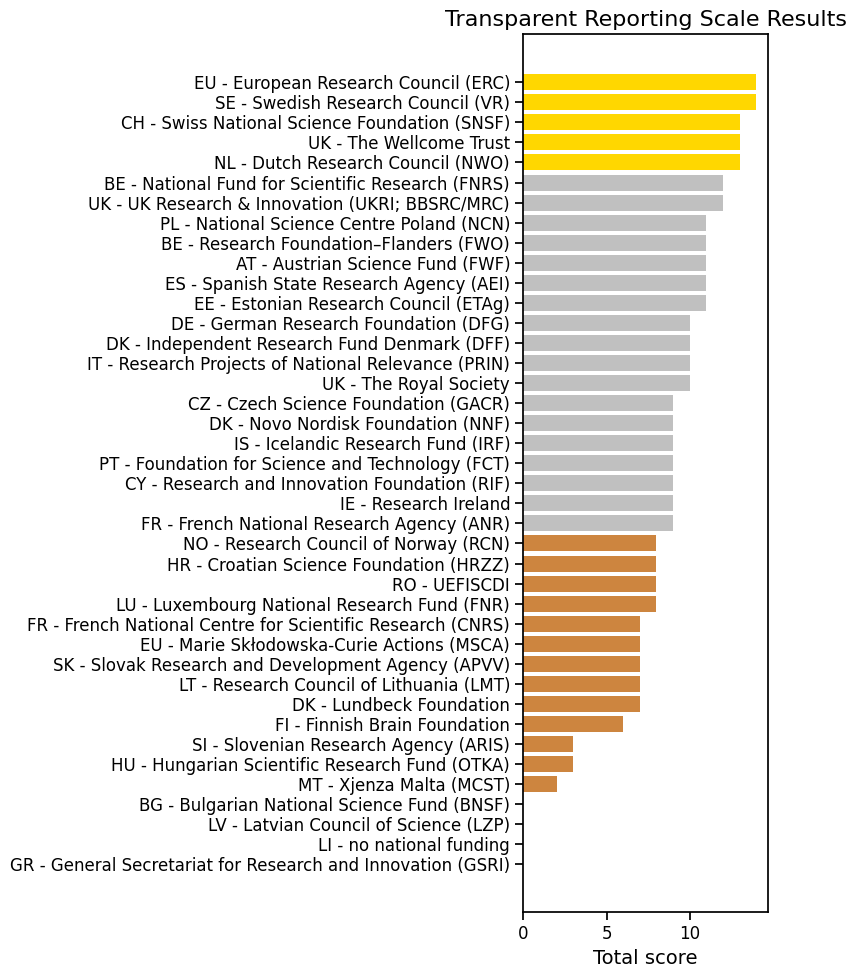

In [14]:
plt.figure(figsize=(8, 10))
plt.barh(
    best_df["label"].astype(str),
    best_df["total_score"],
    color=best_df["color"]
)

plt.xlabel("Total score")
plt.title("Transparent Reporting Scale Results")
plt.tight_layout()
plt.savefig(figures_p / "scale_results.png",dpi=300, bbox_inches="tight")
plt.show()

In [15]:
funders_per_country = df.groupby('country')['label'].nunique().reset_index() 
funders_per_country.columns = ['country', 'num_funders'] 
funders_per_country['country'] = funders_per_country['country'].replace('UK', 'United Kingdom') 
funders_per_country.head()

,country,num_funders
0,Austria,1
1,Belgium,2
2,Bulgaria,1
3,Croatia,1
4,Czech Republic,1


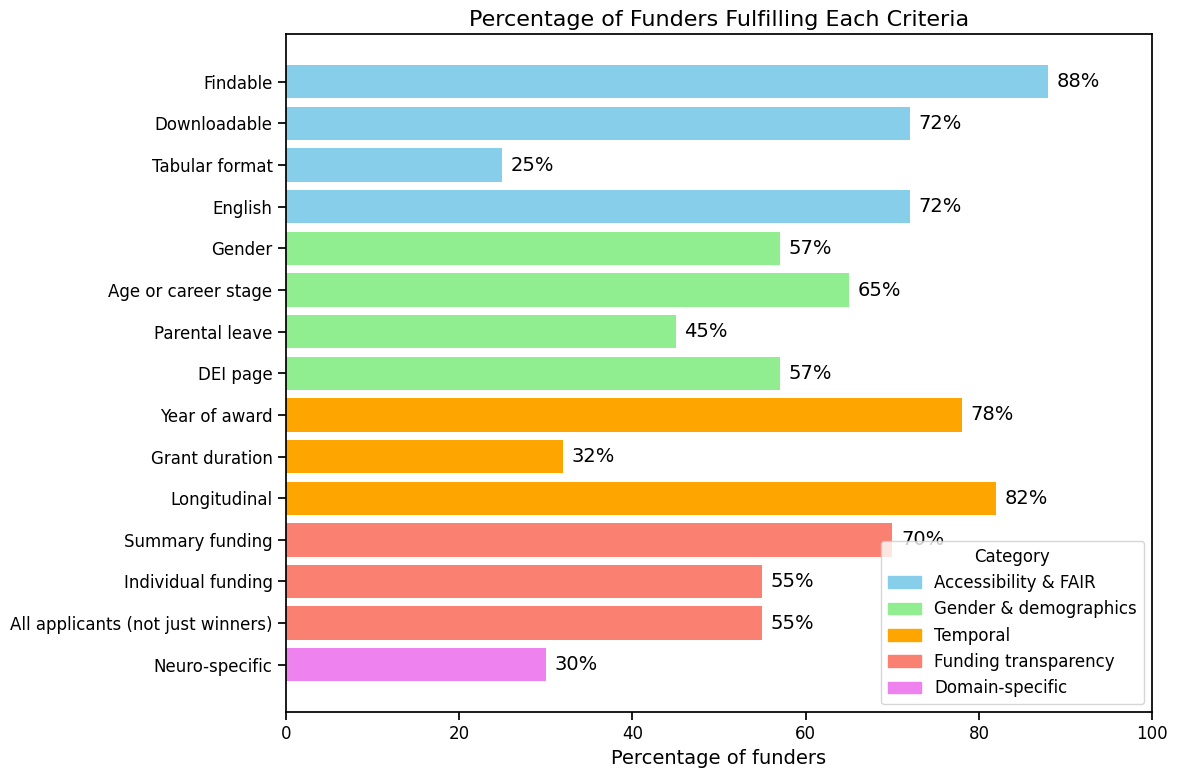

In [16]:
# Mapping for labels and categories
labels = {
    "findable": "Findable",
    "data_downloadable": "Downloadable",
    "tabular": "Tabular format",
    "english_data": "English",
    "gender": "Gender",
    "age_or_career_stage": "Age or career stage",
    "parental_leave": "Parental leave",
    "dei_eo_page": "DEI page",
    "year_of_award": "Year of award",
    "grant_duration": "Grant duration",
    ">=3 years data": "Longitudinal",
    "summary_funding": "Summary funding",
    "per_group_funding": "Individual funding",
    "report_all_applicants": "All applicants (not just winners)",
    "neuro_specific": "Neuro-specific"
}

category_map = {
    "findable": "Accessibility & FAIR",
    "data_downloadable": "Accessibility & FAIR",
    "tabular": "Accessibility & FAIR",
    "english_data": "Accessibility & FAIR",
    "gender": "Gender & demographics",
    "age_or_career_stage": "Gender & demographics",
    "parental_leave": "Gender & demographics",
    "dei_eo_page": "Gender & demographics",
    "year_of_award": "Temporal",
    "grant_duration": "Temporal",
    ">=3 years data": "Temporal",
    "summary_funding": "Funding transparency",
    "per_group_funding": "Funding transparency",
    "report_all_applicants": "Funding transparency",
    "neuro_specific": "Domain-specific"
}

category_colors = {
    "Accessibility & FAIR": "skyblue",
    "Gender & demographics": "lightgreen",
    "Temporal": "orange",
    "Funding transparency": "salmon",
    "Domain-specific": "violet"
}

# Create a DataFrame in the order of labels dictionary
percentages = (funder_max[cols].sum() / len(funder_max) * 100).reindex(cols).round(0)
percentages_df = pd.DataFrame({
    'Measure': cols,
    'Percent_of_Funders': percentages.values
})

# Map labels and categories in the original order
percentages_df['Measure_Label'] = percentages_df['Measure'].map(labels)
percentages_df['Category'] = percentages_df['Measure'].map(category_map)

# Filter out rows where Measure_Label is NaN (measures not in labels dict)
percentages_df = percentages_df.dropna(subset=['Measure_Label'])

# Sort by the order in labels dictionary (maintain original order) and REVERSE
label_order = list(labels.values())
percentages_df['Measure_Label'] = pd.Categorical(
    percentages_df['Measure_Label'], 
    categories=label_order, 
    ordered=True
)
percentages_df = percentages_df.sort_values('Measure_Label')

# Reverse the DataFrame so "Findable" is at the top
percentages_df = percentages_df.iloc[::-1].reset_index(drop=True)

# Define colors for categories
category_colors = {
    "Accessibility & FAIR": "skyblue",
    "Gender & demographics": "lightgreen",
    "Temporal": "orange",
    "Funding transparency": "salmon",
    "Domain-specific": "violet"
}

# Get colors as a list to ensure proper format
colors_list = []
for category in percentages_df['Category']:
    colors_list.append(category_colors.get(category, "gray"))  # Use gray as default if category missing

# Plot
plt.figure(figsize=(12, 8))
bars = plt.barh(percentages_df["Measure_Label"], percentages_df["Percent_of_Funders"], color=colors_list)

# Add percentage labels
for bar in bars:
    width = bar.get_width()
    plt.text(width + 1, bar.get_y() + bar.get_height()/2, f"{width:.0f}%", va='center')

plt.xlabel("Percentage of funders")
plt.title("Percentage of Funders Fulfilling Each Criteria")
plt.xlim(0, 100)

# Create legend
handles = [plt.Rectangle((0,0),1,1,color=color) for color in category_colors.values()]
plt.legend(handles, category_colors.keys(), title="Category") #, bbox_to_anchor=(1.05, 1)

plt.tight_layout()
plt.savefig(figures_p / "percentages_plot.png", dpi=300, bbox_inches="tight")
plt.show()

In [17]:
# How much data is donwloaded?
dd = df[df["data_downloadable"] == 1].copy()

# Number of data records
num_records = len(dd)

# Number of unique funders with downloadable data
num_funders = dd["label"].nunique()

# Number of unique countries with downloadable data
num_countries = dd["country"].nunique()

num_records, num_funders, num_countries

(43, 29, 25)

In [18]:
# What is the data range for the downloaded data?
dd = df[df["data_downloadable"] == 1].copy()

# Earliest start year and latest end year
earliest_start = dd["start_year"].min()
latest_end = dd["end_year"].max()

print(f"Earliest start year: {earliest_start}")
print(f"Latest end year: {latest_end}")

Earliest start year: 1974
Latest end year: 2025


In [19]:
# Analyse correlation between scores and GDP
countries = wb.get_countries()
european_countries = countries[countries['region'] == 'Europe']
#print(european_countries.columns)

In [20]:
# GDP per capita (current USD)
gdp_series = wb.get_series(
    'NY.GDP.PCAP.CD',       # Indicator code for GDP per capita
    country=european_countries['iso2Code'].tolist(),
    date='2024', # This is the latest available
    simplify_index=True   
)
gdp_df = gdp_series.reset_index()
gdp_df.columns = ['Country', 'GDP_per_capita_USD']
print(gdp_df.head())

                          Country  GDP_per_capita_USD
0     Africa Eastern and Southern         1567.635839
1      Africa Western and Central         1284.154441
2                      Arab World         7521.153309
3          Caribbean small states        20173.956475
4  Central Europe and the Baltics        24543.304055


In [21]:
# GDP per capita
gdp_series = wb.get_series(
    'NY.GDP.PCAP.CD',
    country=european_countries['iso2Code'].tolist(),
    date='2024', # Liechtenstein has no data for 2024 (only 2023), but since they have no funders to evaluate, I exclude them anyway
    simplify_index=True
)

gdp_df = gdp_series.reset_index() 
gdp_df.columns = ['Country', 'GDP_per_capita_USD'] 
print(gdp_df.head()) 

# Map some country names in our data to match World Bank names 
name_map = { 'EU': 'European Union', # see paper for limitation
            'Slovakia': 'Slovak Republic', 
            'UK': 'United Kingdom', 
            'Czech Republic': 
            'Czechia', 
            'Republic of Cyprus': 'Cyprus', } 

# Apply mapping 
best_df['country'] = best_df['country'].replace(name_map) 

# Merge with World Bank GDP 
merged_df = pd.merge( best_df, gdp_df[['Country','GDP_per_capita_USD']], left_on='country', right_on='Country', how='left' )

                          Country  GDP_per_capita_USD
0     Africa Eastern and Southern         1567.635839
1      Africa Western and Central         1284.154441
2                      Arab World         7521.153309
3          Caribbean small states        20173.956475
4  Central Europe and the Baltics        24543.304055


In [22]:
# Since some countries have multiple scores, take their max achievement
max_idx = merged_df.groupby('country')['total_score'].idxmax()
df_max = merged_df.loc[max_idx, ['country', 'total_score', 'GDP_per_capita_USD', 'color']].reset_index(drop=True)

In [23]:
# Run correlation
df_max = df_max.dropna(subset=['total_score', 'GDP_per_capita_USD', 'color'])
r, p = stats.pearsonr(df_max['total_score'], df_max['GDP_per_capita_USD'])
print(f"Pearson r = {r:.3f}, p-value = {p:.3f}")

Pearson r = 0.365, p-value = 0.040


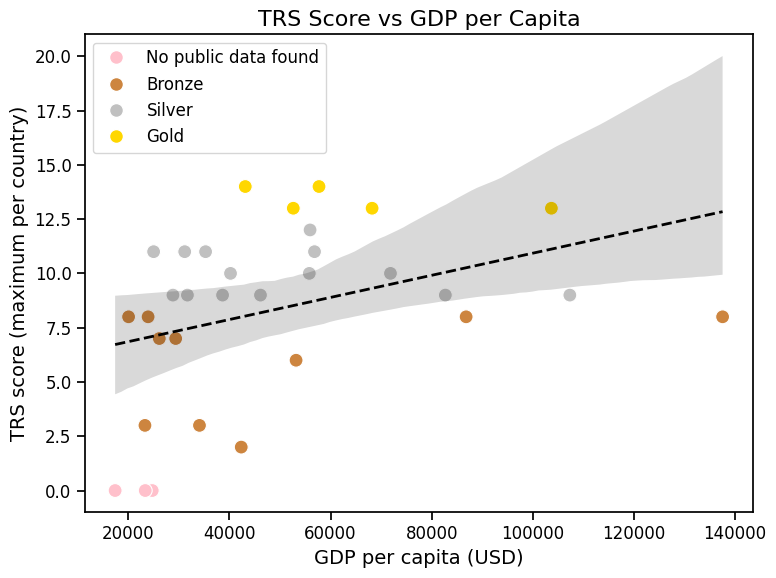

In [24]:
palette_dict = {
    'pink': 'pink',
    'peru': 'peru',
    'silver': 'silver',
    'gold': 'gold'
}

color_descriptions = {
    'pink': 'No public data found',
    'peru': 'Bronze',
    'silver': 'Silver',
    'gold': 'Gold'
}

plt.figure(figsize=(8,6))
sns.scatterplot(
    x='GDP_per_capita_USD',
    y='total_score',
    data=df_max,
    hue='color', 
    palette=palette_dict,
    s=100,
    legend=False 
)

# Add regression line
sns.regplot(
    x='GDP_per_capita_USD',
    y='total_score',
    data=df_max,
    scatter=False,
    line_kws={'color': 'black', 'lw': 2, 'ls': '--'}
)

plt.xlabel('GDP per capita (USD)')
plt.ylabel('TRS score (maximum per country)')
plt.title('TRS Score vs GDP per Capita')

legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='pink', 
           markersize=10, label='No public data found'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='peru', 
           markersize=10, label='Bronze'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='silver', 
           markersize=10, label='Silver'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='gold', 
           markersize=10, label='Gold')]

plt.legend(handles=legend_elements)

plt.tight_layout()
plt.savefig(figures_p / "gdp_plot.png",dpi=300)
plt.show()